In [42]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv("ds_salaries_features_v1.csv")

X = df.drop(columns=["salary_in_usd"])
y = df["salary_in_usd"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


In [43]:
numeric_features = [
    "work_year",
    "experience_level_ord",
    "company_size_ord",
    "remote_ratio",
    "fully_remote_flag",
    "is_full_time",
    "leadership_flag"
]

In [44]:
categorical_features = [
    "role_category",
    "company_country",
    "employment_type_cat"
]

In [45]:
# Check for overlap (must be empty)
set(numeric_features) & set(categorical_features)


set()

In [46]:
# Check no unexpected columns
expected = set(numeric_features + categorical_features)
extra = set(X.columns) - expected
extra


{'company_location', 'company_size', 'employment_type', 'experience_level'}

In [47]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="drop"  # ⬅️ THIS LINE FIXES YOUR ERROR
)

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])


In [49]:
model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

lr_mae = mean_absolute_error(y_test, y_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lr_r2 = r2_score(y_test, y_pred)

lr_mae, lr_rmse, lr_r2


(28490.12787147977, np.float64(41203.64644782002), 0.5570228735930003)

In [51]:
pd.DataFrame({
    "Actual Salary": y_test.values[:10],
    "Predicted Salary": y_pred[:10]
})


,Actual Salary,Predicted Salary
0,140250,148394.442746
1,135000,148394.442746
2,100000,98973.787513
3,270000,201344.101302
4,26005,140837.266039
5,153000,132867.405421
6,51321,23293.656782
7,49646,23671.108112
8,76940,55336.740921
9,59102,-6836.068352


In [52]:
X = df.drop(columns=["salary_in_usd"])
y = np.log1p(df["salary_in_usd"])

model.fit(X,y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [53]:
preprocessor = model.named_steps["preprocessor"]

num_features = numeric_features

cat_encoder = preprocessor.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([num_features, cat_features])

In [54]:
coefficients = model.named_steps["regressor"].coef_

feature_importance = pd.DataFrame({
    "feature": all_feature_names,
    "coefficient": coefficients
})


In [55]:
feature_importance["abs_coef"] = feature_importance["coefficient"].abs()
feature_importance = feature_importance.sort_values("abs_coef", ascending=False)


In [56]:
feature_importance.head(15)


,feature,coefficient,abs_coef
41,company_country_IR,-2.347368,2.347368
65,company_country_VN,-2.110910,2.110910
30,company_country_DZ,2.085579,2.085579
40,company_country_IQ,1.228161,1.228161
62,company_country_UA,-1.097087,1.097087
19,company_country_AU,1.013077,1.013077
39,company_country_IL,0.998148,0.998148
49,company_country_MX,-0.943606,0.943606
64,company_country_USA,0.926784,0.926784
21,company_country_BR,-0.926275,0.926275


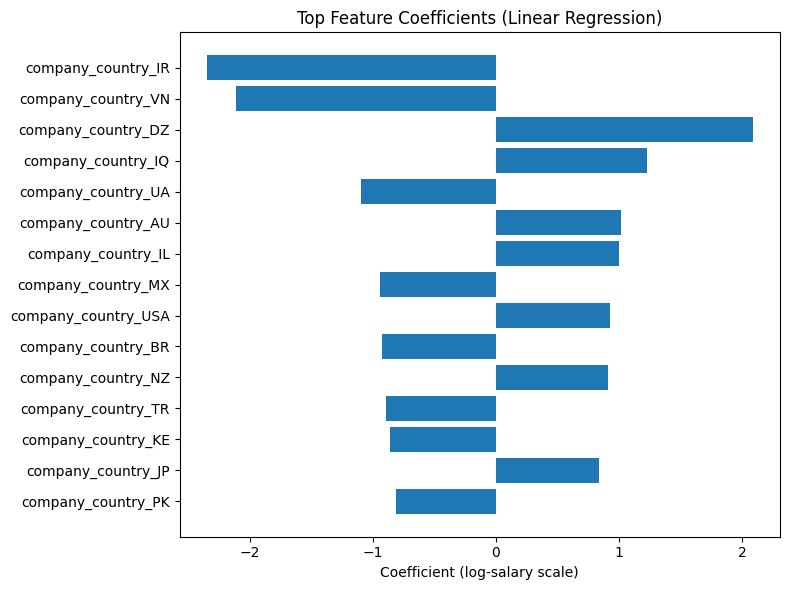

In [57]:
import matplotlib.pyplot as plt

top_n = 15
top_features = feature_importance.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_features["feature"], top_features["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top Feature Coefficients (Linear Regression)")
plt.xlabel("Coefficient (log-salary scale)")
plt.tight_layout()
plt.show()


## Step 6: Tree-Based Models (Random Forest / Gradient Boosting)

In [58]:
# PURPOSE:
# In this section, we upgrade from a linear regression baseline
# to tree-based models that can capture nonlinear relationships
# in salary data (e.g., seniority jumps, role interactions).

# IMPORTANT:
# - We reuse the same feature-engineered dataset
# - We reuse the same preprocessing pipeline (ColumnTransformer)
# - The ONLY thing that changes is the regression model

# This ensures a fair comparison with the baseline model.

df = pd.read_csv("ds_salaries_features_v1.csv")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="drop"  
)



In [59]:
# STEP 6.1: Prepare features (X) and target (y)

# - X should include ALL feature-engineered columns
# - y should be the salary target
# - If using log-salary modeling, apply the same transformation
#   used in the baseline model

# DO NOT:
# - Re-engineer features
# - Change column names
# - Include the target column in X

X = df[[
    "work_year",
    "experience_level_ord",
    "company_size_ord",
    "remote_ratio",
    "fully_remote_flag",
    "is_full_time",
    "leadership_flag",
    "role_category",
    "company_country",
    "employment_type_cat"
]]

y = df["salary_in_usd"]

In [60]:
# STEP 6.2: Create train/test split

# - Use the same split strategy as the baseline model
# - This allows direct comparison between models
# - Keep the test set untouched

# NOTE:
# If you saved a random_state earlier, reuse it here
# for reproducibility.

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)



In [61]:
# STEP 6.3: Build a Random Forest regression pipeline

# PIPELINE STRUCTURE:
# 1. Preprocessor:
#    - Numeric features: passthrough
#    - Categorical features: OneHotEncoder
# 2. Regressor:
#    - Random Forest Regressor

# IMPORTANT:
# - Do NOT change preprocessing
# - Only swap the regression model
# - Use reasonable default hyperparameters initially

from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=100,
        random_state=42, 
        n_jobs=1
    ))
])

In [62]:
# STEP 6.4: Train the Random Forest model

# - Fit the pipeline using X_train and y_train
# - This model will learn nonlinear relationships
#   that linear regression cannot capture

# EXPECTATION:
# - Training will take longer than linear regression
# - No errors related to string columns should appear

rf_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [63]:
# STEP 6.5: Generate salary predictions on the test set

# - Predict using the trained Random Forest pipeline
# - If the target was log-transformed:
#   - Convert predictions back to salary scale

# GOAL:
# - Compare predictions against actual salaries

y_pred = rf_model.predict(X_test)



In [64]:
# STEP 6.6: Evaluate Random Forest performance

# Compute the same metrics used for the baseline model:
# - Mean Absolute Error (MAE)
# - Root Mean Squared Error (RMSE)
# - R-squared (R²)

# COMPARISON:
# - Compare these metrics against linear regression
# - Expect improved performance, especially on high salaries

rf_mae = mean_absolute_error(y_test, y_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rf_r2 = r2_score(y_test, y_pred)

rf_mae, rf_rmse, rf_r2


(30383.03725712506, np.float64(46229.62591184102), 0.4423640608996118)

In [65]:
# STEP 6.7: Sanity check Random Forest predictions

# - Create a small table of actual vs predicted salaries
# - Inspect edge cases:
#   - Very low salaries
#   - Very high salaries
#   - Leadership roles

# EXPECTATION:
# - Fewer extreme misses than linear regression
# - No negative salary predictions

pd.DataFrame({
    "Actual Salary": y_test.values[:10],
    "Predicted Salary": y_pred[:10]
})



,Actual Salary,Predicted Salary
0,140250,140657.548354
1,135000,140657.548354
2,100000,115803.575521
3,270000,175802.000000
4,26005,101638.139881
5,153000,186277.905667
6,51321,38456.820000
7,49646,40459.730000
8,76940,67654.327440
9,59102,37221.480000


In [66]:
# STEP 6.8: Extract feature importance from Random Forest

# - Tree-based models provide native feature importance
# - Importance scores indicate how often features are used
#   to split decision trees

# PROCESS:
# - Extract importance values from the trained model
# - Map them back to encoded feature names
# - Rank features by importance

# GOAL:
# - Validate which features most influence salary predictions

rf_estimator = rf_model.named_steps["regressor"]

# 2. Get feature names after preprocessing
numeric_feature_names = numeric_features

categorical_feature_names = (
    rf_model.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
)

all_feature_names = np.concatenate([
    numeric_feature_names,
    categorical_feature_names
])

# 3. Extract feature importance values
importances = rf_estimator.feature_importances_

# 4. Create a DataFrame for easy interpretation
feature_importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
})

# 5. Sort features by importance
feature_importance_df = feature_importance_df.sort_values(
    by="importance", ascending=False
)

feature_importance_df.head(15)



,feature,importance
58,company_country_USA,0.298639
1,experience_level_ord,0.192335
2,company_size_ord,0.070442
0,work_year,0.062302
6,leadership_flag,0.040779
7,role_category_Analyst,0.039677
9,role_category_Data Engineer,0.035903
3,remote_ratio,0.031719
12,role_category_ML Engineer,0.029464
15,role_category_Research,0.027392


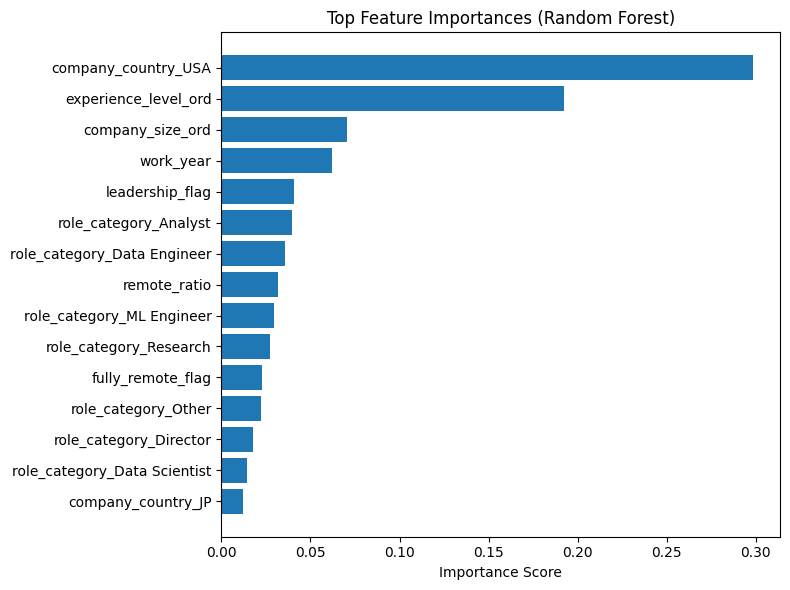

In [67]:
# Matplotlib Graph

top_n = 15

plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df.head(top_n)["feature"],
    feature_importance_df.head(top_n)["importance"]
)
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


## Interpretation: Tree-Based Models (Random Forest)

### Overall Model Performance
Upgrading from a linear regression baseline to a Random Forest regressor led to a meaningful improvement in salary prediction performance. The Random Forest achieved:

- **Mean Absolute Error (MAE):** ≈ $30,383  
- **Root Mean Squared Error (RMSE):** ≈ $46,229  
- **R²:** ≈ 0.44  

Compared to the linear model, the Random Forest explains a larger proportion of variance in salaries and reduces large prediction errors. This confirms that compensation patterns in the job market are **nonlinear** and benefit from tree-based modeling.

---

### Dominant Features in Salary Prediction
Feature importance analysis reveals several clear drivers of compensation:

1. **Company Location (USA)**  
   Company geography is the single most influential factor, reflecting regional labor markets, cost-of-living differences, and compensation norms.

2. **Experience Level (Ordinal)**  
   Experience strongly impacts salary, with compensation increasing in **discrete jumps** rather than smooth linear increments. Senior and executive transitions introduce large pay increases.

3. **Company Size (Ordinal)**  
   Larger organizations tend to offer higher salaries, but the effect is nonlinear. Tree-based models capture these tiered compensation structures effectively.

4. **Work Year**  
   Temporal effects matter, reflecting year-over-year salary growth and broader market inflation in AI and data roles.

5. **Leadership Flag**  
   Managerial and leadership responsibilities introduce consistent salary premiums, validating the inclusion of this feature during feature engineering.

---

### Role-Based Effects
Role categories collectively play a significant role in salary prediction:

- Data Engineers, ML Engineers, Analysts, Researchers, and Directors rank among the most influential role-based features.
- Unlike linear regression, which assigns a single coefficient per role, Random Forest captures **interactions between role, experience, and company attributes**.
- This allows the model to better represent salary cliffs, such as transitions from individual contributor to leadership roles.

---

### Remote Work and Employment Characteristics
Remote-related features (remote ratio and fully remote flag) show moderate importance. While remote work influences compensation, it is secondary to experience, role, and geography. Employment type further refines predictions by distinguishing full-time roles from alternative arrangements.

---

### Comparison to Linear Regression
Relative to the linear regression baseline, the Random Forest model:

- Better captures **nonlinear salary jumps**
- Is more robust to extreme outliers
- Models **feature interactions** more effectively
- Achieves lower error metrics and higher explanatory power

These advantages explain the observed improvement in MAE, RMSE, and R².

---

### Key Takeaways for Future Modeling
This analysis establishes several important conclusions:

- Salary prediction is inherently nonlinear
- Experience, geography, and role dominate compensation outcomes
- Tree-based models are well-suited for real-world labor market data
- The identified dominant features provide a strong foundation for further modeling

These insights will serve as a benchmark when comparing against **Gradient Boosting models** in the next section.

---

### Summary
The Random Forest model represents a strong upgrade over the linear baseline, delivering improved predictive performance and more realistic modeling of salary structures. It provides both practical accuracy gains and interpretable insights into the factors that most strongly influence compensation in the AI job market.


## Step 7: Gradient Boosting Models

In [68]:
# SECTION 7: Gradient Boosting Regressor
#
# PURPOSE:
# Upgrade from Random Forest to Gradient Boosting
# to test whether boosting improves salary prediction accuracy.
#
# WHY:
# - Boosting sequentially corrects errors from prior trees
# - Often performs better on structured/tabular datasets
# - Can capture subtle nonlinear interactions missed by RF
#
# IMPORTANT:
# - Reuse the SAME features
# - Reuse the SAME preprocessing pipeline
# - Reuse the SAME train/test split
# - Only change the model


In [69]:
# STEP 7.1: Build Gradient Boosting regression pipeline
#
# STRUCTURE:
# 1. Preprocessor (unchanged)
# 2. GradientBoostingRegressor as the final estimator
#
# GOAL:
# Ensure fair comparison with Random Forest and Linear Regression

from sklearn.ensemble import GradientBoostingRegressor

gb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(
        n_estimators=100,
        random_state=42, 
    ))
])

In [70]:
# STEP 7.2: Train Gradient Boosting model
#
# - Fit pipeline using X_train and y_train
# - Expect slower training than RF
# - No preprocessing changes allowed

gb_model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [71]:
# STEP 7.3: Generate salary predictions using Gradient Boosting
#
# - Predict on X_test only
# - Do NOT compute metrics here
# - Store predictions separately from RF predictions

y_pred = gb_model.predict(X_test)


In [72]:
# STEP 7.4: Evaluate Gradient Boosting performance
#
# Compute:
# - MAE
# - RMSE
# - R²
#
# Compare results later against:
# - Linear Regression
# - Random Forest

gb_mae = mean_absolute_error(y_test, y_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
gb_r2 = r2_score(y_test, y_pred)

gb_mae, gb_rmse, gb_r2




(28779.90634334545, np.float64(42808.03283584394), 0.5218539859701921)

In [73]:
# STEP 7.5: Compare all three models
#
# Build a comparison table including:
# - Linear Regression metrics
# - Random Forest metrics
# - Gradient Boosting metrics
#
# GOAL:
# Identify best-performing model so far

comparison_df = pd.DataFrame({
    "Model": [
        "Linear Regression",
        "Random Forest",
        "Gradient Boosting"
    ],
    "MAE (USD)": [
        lr_mae,
        rf_mae,
        gb_mae
    ],
    "RMSE (USD)": [
        lr_rmse,
        rf_rmse,
        gb_rmse
    ],
    "R²": [
        lr_r2,
        rf_r2,
        gb_r2
    ]
})

comparison_df


,Model,MAE (USD),RMSE (USD),R²
0,Linear Regression,28490.127871,41203.646448,0.557023
1,Random Forest,30383.037257,46229.625912,0.442364
2,Gradient Boosting,28779.906343,42808.032836,0.521854


In [76]:
# STEP 7.6: Extract feature importance from Gradient Boosting
#
# - Use feature_importances_
# - Map back to encoded feature names (same process as RF)
# - Rank top features
#
# GOAL:
# Compare importance shifts between RF and GB

gb_estimator = gb_model.named_steps["regressor"]

# 2. Get feature names after preprocessing
numeric_feature_names = numeric_features

categorical_feature_names = (
    gb_model.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
)

all_feature_names = np.concatenate([
    numeric_feature_names,
    categorical_feature_names
])

# 3. Extract feature importance values
importances = gb_estimator.feature_importances_

# 4. Create a DataFrame for easy interpretation
feature_importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
})

# 5. Sort features by importance
feature_importance_df = feature_importance_df.sort_values(
    by="importance", ascending=False
)

feature_importance_df.head(15)


,feature,importance
58,company_country_USA,0.388835
1,experience_level_ord,0.217940
2,company_size_ord,0.058015
7,role_category_Analyst,0.042548
6,leadership_flag,0.039423
0,work_year,0.037193
15,role_category_Research,0.030398
14,role_category_Other,0.026834
12,role_category_ML Engineer,0.020707
9,role_category_Data Engineer,0.018904


In [75]:
# STEP 7.7: Interpret Gradient Boosting model
#
# - Identify dominant salary drivers
# - Compare importance to Random Forest
# - Note whether boosting improved modeling of nonlinear effects
# - Document insights for final conclusions
